# Clinvar Analysis v4
Author: Peter DeWeirdt  
Affiliation: Genetic Perturbation Platform, Broad Institute  
Github: https://github.com/PeterDeWeirdt 

Here we analyze data from C > T base editor screens targetting SNPs from ClinVar. This analysis is part of the paper "Massively parallel assessment of human variants with base editor screens" by Hanna et al. 

#### Packages and versions

In [1]:
import pandas as pd
from scipy import stats
from scipy.interpolate import interpn
from matplotlib import ticker
import numpy as np
import seaborn as sns
import io
import requests
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from adjustText import adjust_text
import re
from statsmodels.stats.multitest import multipletests

In [2]:
import sys
print('Python version: ' + sys.version)

Python version: 3.8.2 | packaged by conda-forge | (default, Mar  5 2020, 16:54:44) 
[Clang 9.0.1 ]


In [3]:
modules = ['pandas', 'scipy', 'matplotlib', 'numpy', 'seaborn', 'io', 'requests', 
           'sklearn', 'matplotlib', 'adjustText', 're']
for module in modules:
    try:
        print(module + ' ' + sys.modules[module].__version__)
    except:
        print(module + ' has no __version__ attribute')

pandas 1.0.2
scipy 1.4.1
matplotlib 3.2.1
numpy 1.18.1
seaborn 0.10.0
io has no __version__ attribute
requests 2.23.0
sklearn 0.22.2.post1
matplotlib 3.2.1
adjustText has no __version__ attribute
re 2.2.1


#### Custom functions

In [4]:
def cm2inch(*tupl):
    # helper function for creating figures
    # convert tuple of centimeters to inches
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def build_request_url(method, output_format = 'tsv'):
    # helper function for creating URL to query the string database
    string_api_url = "https://string-db.org/api"
    request_url = "/".join([string_api_url, output_format, method])
    return request_url

def handle_results(results):
    # helper function to interpret results returned from the string database
    if results.ok:
        data = results.content.decode('utf8')
        df = pd.read_csv(io.StringIO(data), sep = '\t')
        return df
    else:
        raise ValueError(results.reason)
    
def point_density_plot(x_col, y_col, data = None, bins = [20,20], pearson=True, **kwargs): 
    """Scatter plot with points colored by density
    
    Rasterized scatterplot for easy illustrator import
    Args:
        x_col: what to plot on the x axis
        y_col: what to plot on the y axis
        data: dataframe with x_col and y_col
        bins: binsize for density estimate
        pearson: whether to include pearson correlation coefficient
        kwargs: additional aruments passed to scatterplot function
    
    Returns: 
        axis object
    """
    df = data.copy()
    x = df[x_col]
    y = df[y_col]
    hist_data, x_e, y_e = np.histogram2d(x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), hist_data, np.vstack([x,y]).T, method = "splinef2d", bounds_error = False)
    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0   
    df['color'] = z
    df = df.sort_values('color', ascending = True)
    if pearson:
        r = np.round(stats.pearsonr(x, y)[0], 2)
        plt.text(x.min(), y.max(), 'R = ' + str(r), size = 8, va = 'top', ha = 'left')
    ax = sns.scatterplot(x = x_col, y = y_col, data = df, hue = 'color', 
                         alpha = 0.6, edgecolor='', 
                         marker='o', rasterized=True,
                         palette = 'viridis', legend = False, **kwargs)
    return ax

def point_scatter_plot(x_col, y_col, data = None, pearson=True, **kwargs): 
    """Regular ol' scatter plot
    
    Args:
        x: what to plot on the x axis
        y: what to plot on the y axis
        data: dataframe with x_col and y_col
        pearson: whether to include pearson correlation coefficient
        kwargs: additional aruments passed to scatterplot function
    
    Returns: 
        axis object
    """
    df = data.copy()
    x = df[x_col]
    y = df[y_col]
    if pearson:
        r = np.round(stats.pearsonr(x, y)[0], 2)
        plt.text(x.min(), y.max(), 'R = ' + str(r), size = 8, va = 'top', ha = 'left')
    ax = sns.scatterplot(x = x_col, y = y_col, data = df, edgecolor='', 
                         marker='o', **kwargs)
    return ax

def stacked_bar(x, y, hue, data, hue_order = None, y_order = None, legend_title = None, **kwargs):
    """Create a horizantil stacked bar chart
    
    Args:
        x: value on x axis
        y: label on y axis
        hue: color separating stack
        data: df with columns x, y, hue and hue_order
        hue_order: order of colors
        y_order: order of y axis
        legend_title:
        
    Returns:
        Axis object
    """
    df = data.copy()
    if hue_order:
        df[hue] = pd.Categorical(df[hue], hue_order)
    if y_order:
        df[y] = pd.Categorical(df[y], y_order)
        df = df.sort_values([y])
    df = df.sort_values(hue)
    df['rolling_x'] = df.groupby(y)[x].cumsum()
    unique_hues = list(reversed(df[hue].unique()))
    for h in unique_hues:
        hue_data = df[df[hue] == h]
        plt.barh(hue_data[y], hue_data['rolling_x'], **kwargs)
    plt.legend(unique_hues, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1, title = legend_title)
    return plt.gca()

#### Plot style

In [5]:
sns.set(style='ticks', palette='Set2', font='Arial', context = 'paper')
plt.rcParams['svg.fonttype'] = 'none' # allows the local filesystem to load the font

#### Loading data

In [6]:
lfcs = pd.read_csv('../Data/Filtered_LFC_files/ClinVar_AADW08_filtered_v1.csv')
# library annotations for describing designs
unfiltered_annotations = pd.read_csv('../Data/Annotations/ClinVar_GC/AADW08_annotation_v1.csv')
snp_annotations = pd.read_csv('../Data/Annotations/ClinVar_GC/snp_df_Full_Library_new_variants.txt', 
                             sep = '\t')
vep_annotations = pd.read_csv('../Data/Annotations/ClinVar_GC/clinvar_gc_filtered_CT_VEP_annotation_2020-03-16_v1.txt', 
                          sep = '\t')
essential_genes = pd.read_csv('../Data/Annotations/ClinVar_GC/hart_essential_genes.txt', sep = '\t')
brca1 = pd.read_csv('../Data/Filtered_LFC_files/BRCA1_AAEG04_RDA256_filtered_v6.csv')
brca2 = pd.read_csv('../Data/Filtered_LFC_files/BRCA2_AAEG05_RDA256_filtered_v6.csv')

/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
brca1.columns = [re.sub('Meljuso', 'MELJUSO', x) for x in brca1.columns]
brca2.columns = [re.sub('Meljuso', 'MELJUSO', x) for x in brca2.columns]

In [8]:
# Define a 'gene' using two different columns from the lfc file
# Use Gene_y column if it exists. This column is more comprehensive, so if a
# guide targets multiple genes then it will have both genes separated by a ';'
# Otherwise use Gene_x -- generally these are controls if not in Gene_y
# Finally if neither, define the gene by the edit
def define_gene(row):
    if pd.notna(row['Gene_y']):
        genes = []
        for gene in row['Gene_y'].split(';'):
            if gene != 'nan':
                genes.append(gene)
        return ';'.join(genes)
    elif pd.notna(row['Gene_x']):
        return row['Gene_x']
    else:
        return row['Edit']

lfcs['Gene'] = lfcs.apply(define_gene, axis = 1)
# some "gene" columns had an irregular ClinVar format, so they were annotated with there clinical consequence
# instead of their gene name
misaligned_genes = {'p.Arg1416Cys':'TTN', 'p.Arg3367Gln': 'TTN', 
                    'p.Arg801His': 'RTEL1', 'p.Glu748=': 'TTN', 
                    '12-Sep':'SEPTIN12', '9-Sep':'SEPTIN9'} # and some dates
lfcs['Gene'] = [misaligned_genes[g] if g in misaligned_genes.keys() else g for g in lfcs['Gene']]
lfcs.columns = [re.sub('Meljuso', 'MELJUSO', x) for x in lfcs.columns]
# We use the ONE_NON-GENE_SITE guides to Z-score the LFCs
def z_score_lfcs(df, col, ref_gene = 'ONE_NON-GENE_SITE'):
    genes = np.array([x[2] for x in df['Construct IDs'].str.split(';')])
    lfcs = df[col].values
    sd = np.std(lfcs[genes == ref_gene])
    mean = np.mean(lfcs[genes == ref_gene])
    z_score = (lfcs - mean)/sd
    base_name = ';'.join(col.split(';')[:-1])
    df[base_name + ';z_score'] = z_score
    return df
# use a regex to find all columns with 'lfc in them'
r = re.compile('lfc')
be_lfc_cols = list(filter(r.search, lfcs.keys()))
for col in be_lfc_cols:
    lfcs = z_score_lfcs(lfcs, col)

## Dataset Overview
Here we look at how many SNPs of each Clinical signifance we can target with base editors

In [9]:
# 68526 guides total
editing_guides = unfiltered_annotations[unfiltered_annotations.Type == 'single nucleotide variant']
edits = editing_guides['#AlleleID'].str.split(';').explode()
unique_edits = edits.unique()

Note that all annotations are single nucleotide variants

In [10]:
snp_annotations.Type.unique()

array(['single nucleotide variant'], dtype=object)

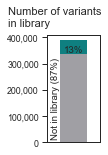

In [11]:
lib_count = pd.DataFrame({'Not in library': snp_annotations.shape[0] - len(unique_edits), 'In library': len(unique_edits)}, index = ['ClinVar SNPs'])
fig, ax = plt.subplots(figsize = cm2inch(2.4,5))
lib_count.plot.bar(stacked = True, color = ['#A09FA4', '#0F7F80'], linewidth = 0, ax = ax)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Number of variants\nin library', ha = 'left', size = 11)
ax.title.set_position((-0.75,1.03))
plt.annotate('13%', (0, lib_count['Not in library']), ha = 'center', va = 'bottom')
plt.annotate('Not in library (87%)', (-0.25, 10000), ha = 'right', va = 'bottom', rotation= 90)
plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/targetable.svg', dpi = 150, bbox_inches = "tight")

In [12]:
# To calculate the number of genes in the SNP file, count any string in the "Name" column,
# which is in parentheses and only contains upper case letters and numbers. 
def get_gene(Name):
    parens = re.findall('\((.*?)\)', Name)
    genes = []
    for s in parens:
        if all(c.isdigit() or c.isupper() for c in s):
            genes.append(s)
    return ';'.join(genes)

editing_guides['gene'] = [get_gene(name) for name in editing_guides['Name']]
genomic_loci = editing_guides.gene.str.split(';').explode().unique()
# Subtract one for empty string
gene_targets = len(genomic_loci) -  1
print(str(gene_targets) + ' gene targets')

3584 gene targets


<ipython-input-12-ed50607ed9d9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  editing_guides['gene'] = [get_gene(name) for name in editing_guides['Name']]


## Data QC

### Cell line correlation

/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/seaborn/relational.py:918: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  scout = ax.scatter([], [], **kws)
/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/seaborn/relational.py:955: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  points = ax.scatter(*args, **kws)


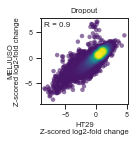

In [13]:
sns.set(style='ticks', palette='Set2', font='Arial', context = 'paper', font_scale = 0.8)
fig, ax = plt.subplots(figsize = cm2inch((4, 4)))
ax = point_density_plot('HT29;AADW08;RDA077;Dropout;AvgABC;D21;z_score', 
                        'MELJUSO;AADW08;RDA077;Dropout;AvgABC;D21;z_score', lfcs, s=20, ax=ax)
plt.xlabel('HT29\nZ-scored log2-fold change')
plt.ylabel('MELJUSO\nZ-scored log2-fold change')
plt.title('Dropout')
plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/dropout_guides.svg', dpi = 150, bbox_inches = "tight")

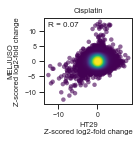

In [14]:
fig, ax = plt.subplots(figsize = cm2inch((4, 4)))
ax = point_density_plot('HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score', 
                        'MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score', lfcs, s=20, ax=ax)
plt.xlabel('HT29\nZ-scored log2-fold change')
plt.ylabel('MELJUSO\nZ-scored log2-fold change')
plt.title('Cisplatin')
plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/cisplatin_guides.svg', dpi = 150, bbox_inches = "tight")

### Comparison with BRCA screens

In [15]:
clinvar_cisplatin = lfcs.loc[:, ['sgRNA sequence', 'Construct IDs', 'Gene',
                                                'MELJUSO;AADW08;RDA077;Dropout;AvgABC;D21;lfc_pdna', 
                                                'MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;lfc_dropout']].copy()
clinvar_cisplatin['MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;lfc_pdna'] = clinvar_cisplatin['MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;lfc_dropout'] + clinvar_cisplatin['MELJUSO;AADW08;RDA077;Dropout;AvgABC;D21;lfc_pdna']

#### BRCA1

In [16]:
filtered_brca1 = brca1.loc[brca1['Gene Symbol'] == 'BRCA1', ['sgRNA sequence', 'Construct IDs',
                                                             'MELJUSO;AAEG04;RDA256;Cisplatin;MedABC;D21;lfc_pdna']]
merged_brca1 = filtered_brca1.merge(clinvar_cisplatin, how = 'inner', on = 'sgRNA sequence')

Note that there are some differences between the two libraries, largely based on how deep into an intron we go

In [17]:
pd.options.display.max_colwidth = 100
clinvar_brca1 = clinvar_cisplatin[clinvar_cisplatin.Gene == 'BRCA1']
clinvar_brca1.loc[~clinvar_brca1['sgRNA sequence'].isin(merged_brca1['sgRNA sequence']), 'Construct IDs']

9                     AGGCCTTCACCCTCTGCTCT;NM_007294.3(BRCA1):c.-44C>T;BRCA1
20                    GAGGCCTTCACCCTCTGCTC;NM_007294.3(BRCA1):c.-44C>T;BRCA1
64                    ACTGGGCCCCTGCGCTCAGG;NM_007294.3(BRCA1):c.-61C>T;BRCA1
90                    ACTACCTTTACCCAGAGCAG;NM_007294.3(BRCA1):c.-20G>A;BRCA1
104                   TCACCCTCTGCTCTGGGTAA;NM_007294.3(BRCA1):c.-37C>T;BRCA1
948      AAACTTCTCAACCAGAAGAA;NM_007294.3(BRCA1):c.154C>T (p.Leu52Phe);BRCA1
3968              GAAGCGGCCCATCTCTGCAA;NM_007294.3(BRCA1):c.5277+78G>A;BRCA1
4534               AGTCCCGGGAAAGGGACAGG;NM_007294.3(BRCA1):c.-20+11C>T;BRCA1
10620                GTGAGCTCGCTGAGACTTCC;NM_007294.3(BRCA1):c.-116C>T;BRCA1
11923             ATCCGGAGAGTGTAGGGTAG;NM_007294.3(BRCA1):c.5333-77C>T;BRCA1
13068               AGGCATCTCAGCTGGGCCTT;NM_007294.3(BRCA1):c.*5860C>T;BRCA1
16057              TAGAGTCCCGGGAAAGGGAC;NM_007294.3(BRCA1):c.-20+11C>T;BRCA1
20152           AGGCCCATTGTAGTAAGAAG;NM_007294.3(BRCA1):c.4357+2519C>T;BRCA1

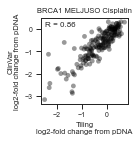

In [18]:
fig, ax = plt.subplots(figsize = cm2inch(4, 4))
point_scatter_plot('MELJUSO;AAEG04;RDA256;Cisplatin;MedABC;D21;lfc_pdna', 
                   'MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;lfc_pdna', merged_brca1, 
                   ax = ax, color = 'black', alpha = 0.4)
plt.xlabel('Tiling\nlog2-fold change from pDNA')
plt.ylabel('ClinVar\nlog2-fold change from pDNA')
plt.title('BRCA1 MELJUSO Cisplatin')
plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/BRCA1 comparison.svg', dpi = 150, bbox_inches = "tight")

#### BRCA2

In [19]:
filtered_brca2 = brca2.loc[brca2['Gene Symbol'] == 'BRCA2', ['sgRNA sequence', 'Construct IDs',
                                                             'MELJUSO;AAEG05;RDA256;Cisplatin;MedABC;D21;lfc_pdna']]
merged_brca2 = filtered_brca2.merge(clinvar_cisplatin, how = 'inner', on = 'sgRNA sequence')
clinvar_brca2 = clinvar_cisplatin[clinvar_cisplatin.Gene == 'BRCA2']
#differnces in UTRs/introns
clinvar_brca2.loc[~clinvar_brca2['sgRNA sequence'].isin(merged_brca2['sgRNA sequence']), 'Construct IDs']

37           CCACCACTAACCCGCTCCAG;NM_000059.3(BRCA2):c.-40+7G>A;BRCA2
168        TACCGTAGTCCCCTATTCAT;NM_000059.3(BRCA2):c.681+209C>T;BRCA2
601      CCAGCCGTTCGGGCCGCTAC;NM_000059.3(BRCA2):c.9257-6738C>T;BRCA2
803            CTGGAGCGGGTTAGTGGTGG;NM_000059.3(BRCA2):c.-42C>T;BRCA2
2402     ATCACGATGGTCATGTTTCC;NM_000059.3(BRCA2):c.9256+3870G>A;BRCA2
5817      CATCCCTCCTCCTGAGCCCC;NM_000059.3(BRCA2):c.316+2827C>T;BRCA2
5923           GCACCTCTGGAGCGGGTTAG;NM_000059.3(BRCA2):c.-51C>T;BRCA2
6781      TGCCATAGGAAGGTACTGTG;NM_000059.3(BRCA2):c.7618-250G>A;BRCA2
6922     AAAAGTTCTACTAGTACTGA;NM_000059.3(BRCA2):c.7007+1407C>T;BRCA2
9478     GGTATCCAGGGTTTGGTAAA;NM_000059.3(BRCA2):c.7008-1104C>T;BRCA2
10450     AATTGATCTATAACCAAGGA;NM_000059.3(BRCA2):c.316+2212C>T;BRCA2
11580    TAACTGGCGGGTATAGGGTG;NM_000059.3(BRCA2):c.9256+7215C>T;BRCA2
13866    TCTTCTTGCCCTGAAGCTTT;NM_000059.3(BRCA2):c.9256+5182C>T;BRCA2
17023    TTCTTCTTGCCCTGAAGCTT;NM_000059.3(BRCA2):c.9256+5182C>T;BRCA2
18692      ATACCGTAG

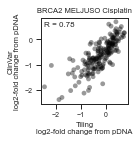

In [20]:
fig, ax = plt.subplots(figsize = cm2inch(4, 4))
point_scatter_plot('MELJUSO;AAEG05;RDA256;Cisplatin;MedABC;D21;lfc_pdna', 
                   'MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;lfc_pdna', merged_brca2, 
                   ax = ax, color = 'black', alpha = 0.4)
plt.xlabel('Tiling\nlog2-fold change from pDNA')
plt.ylabel('ClinVar\nlog2-fold change from pDNA')
plt.title('BRCA2 MELJUSO Cisplatin')
plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/BRCA2 comparison.svg', dpi = 150, bbox_inches = "tight")

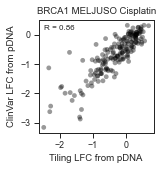

In [21]:
sns.set(style='ticks', palette='Set2', font='Arial', context = 'paper')
fig, ax = plt.subplots(figsize = cm2inch(5.25, 5.25))
point_scatter_plot('MELJUSO;AAEG04;RDA256;Cisplatin;MedABC;D21;lfc_pdna', 
                   'MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;lfc_pdna', merged_brca1, 
                   ax = ax, color = 'black', alpha = 0.4)
plt.xlabel('Tiling LFC from pDNA')
plt.ylabel('ClinVar LFC from pDNA')
plt.title('BRCA1 MELJUSO Cisplatin')
plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/BRCA1 comparison big.svg', dpi = 150, bbox_inches = "tight")

### Enrichment
#### ClinVar Enrichment

In [22]:
# Use the genomic context to get the number of non-gc edits targetting a ClinVar locus. 
# Here we assume each locus is defined by a single genomic context.
# If a guide is oriented in the sense direction, then don't count edits where the last nt
# of the preceding context is not a G
# If a guide is oriented in the antisense direction, then don't count edits where the first nt
# of the succeeding context is a C (complement of G)
def get_nongc_clinvar(row):
    """Helper function to calculate the number of non-GC edits made targetting clinvar SNPS
    
    Args: 
        row: row of lfc df"""
    if pd.isna(row['Genomic_Context']):
        return np.nan
    n_edits = 0 
    # ignoring the four cases where a guide targets a sense and antisense locus
    guide_orientation = row['Strand']
    if guide_orientation == 'sense':
        # read left to right if sense
        split_preceding = row['Preceding_Genomic_Context'].split(';')
        for preceding in split_preceding:
            if preceding[-1] != 'G':
                n_edits +=1
    elif guide_orientation == 'antisense':
        # antisense - edit is made adjacent to the compliment of the first nucleotide of the succeeding context
        # don't count C's in this position as their compliment is a G
        split_succeeding = row['Succeeding_Genomic_Context'].split(';')
        for succeeding in split_succeeding:
            if succeeding[0] != 'C':
                n_edits += 1
    return n_edits

def nongc_count(guide):
    return len(re.findall('(?=(A|C|T)C)', guide[2:8]))

def get_nongc(row):
    if pd.isnull(row['Start']):
        return nongc_count(row['sgRNA sequence'])
    start_split = row['Start'].split(';')
    n_loci = 0
    ranges = []
    for start in start_split:
        n_start = int(start)
        new_loci = True
        for r in ranges:
            if n_start in range(r[0], r[1]):
                new_loci = False
        if new_loci:
            ranges.append((n_start - 5, n_start + 5))
            n_loci += 1
    return n_loci*nongc_count(row['sgRNA sequence'])
            
        
lfcs['ClinVar_nonGC_edits'] = lfcs.apply(get_nongc_clinvar, axis = 1)
lfcs['total_nonGC_edits'] = lfcs.apply(get_nongc, axis = 1)
lfcs['nonGC_bystanders'] = lfcs['total_nonGC_edits'] - lfcs['ClinVar_nonGC_edits']

Comparing with our old bystander annotations, the major shift is towards fewer bystander edits, since we're no longer counting GC edits. However, we do get more bystander edits in some instances, since we're multiplying the number of bystander edits by the number of ClinVar targets. I.e. if a guide targets multiple genes in ClinVar, then we multiply its bystander edits

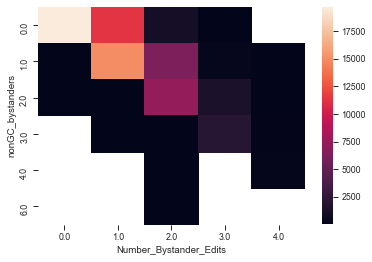

In [23]:
pivoted_counts = lfcs.groupby(['nonGC_bystanders', 'Number_Bystander_Edits']).agg({'sgRNA': 'count'}).reset_index().pivot(index = 'nonGC_bystanders', columns = 'Number_Bystander_Edits', values = 'sgRNA')
sns.heatmap(pivoted_counts)

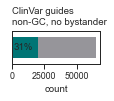

In [24]:
high_quality_edits = lfcs[(lfcs.ClinVar_nonGC_edits == 1) & (lfcs.nonGC_bystanders == 0)].copy()
n_clean_edits = high_quality_edits.shape[0]
n_edits = lfcs[~lfcs['Genomic_Context'].isnull()].shape[0]
fig, ax = plt.subplots(figsize = cm2inch((4,1.5)))
plt.barh(0, n_edits, color = '#96959A', linewidth = 0, height = 0.4)
plt.barh(0, n_clean_edits, color = '#007575', linewidth = 0, height = 0.4)
plt.annotate("{:.0%}".format(n_clean_edits/n_edits), (1000, 0), ha = 'left', va = 'center')
plt.ylim(-0.3, 0.3)
plt.yticks([])
plt.xlabel('count')
plt.title('ClinVar guides\nnon-GC, no bystander', ha = 'left')
ax.title.set_position((0,1.03))
plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/clean_edits.svg', dpi = 150, bbox_inches = "tight")

We'll map the ClincalSignificances to cosolidate between Benign evidence, Pathogenic evidence, Conflicting evidence and other

0
Power_divergenceResult(statistic=0.0, pvalue=1.0)
2
Power_divergenceResult(statistic=18181.027826583715, pvalue=0.0)
hi
4
Power_divergenceResult(statistic=20221.21922354656, pvalue=0.0)
hi


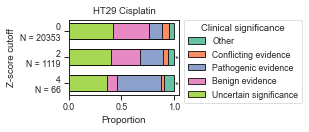

In [25]:
annotation_categories = {'Uncertain significance': 'Uncertain significance', 
                         'Likely benign': 'Benign evidence',
                         'Benign': 'Benign evidence',
                         'Conflicting interpretations of pathogenicity': 'Conflicting evidence',
                         'Benign/Likely benign': 'Benign evidence',
                         'Pathogenic': 'Pathogenic evidence',
                         'Likely pathogenic': 'Pathogenic evidence',
                         'Pathogenic/Likely pathogenic': 'Pathogenic evidence'}
high_quality_edits['Condensed Clinical Significance'] = [annotation_categories[key] if key in annotation_categories.keys() else 'Other' for key in high_quality_edits.ClinicalSignificance]
cutoffs = [0,2,4]
def get_clinsig_dist_df(df, col, cutoffs):
    clin_sig_dist_list = []
    for z in cutoffs:
        relevant_edits = df[df[col].abs() > z]
        edits_dist = (relevant_edits['Condensed Clinical Significance']
                      .value_counts()
                      .reset_index(name = 'n')
                      .rename({'index': 'Condensed Clinical Significance'}, axis = 1))
        edits_dist['cutoff'] = str(z)
        clin_sig_dist_list.append(edits_dist)
    bound_edit_dist = pd.concat(clin_sig_dist_list, axis = 0)
    bound_edit_dist['total'] = bound_edit_dist.groupby('cutoff').n.transform(lambda x: (x/x)*x.sum())
    bound_edit_dist['fraction'] = bound_edit_dist.n/bound_edit_dist.total
    bound_edit_dist['name'] = bound_edit_dist.cutoff + '\nN = ' + bound_edit_dist.total.astype(str)
    return bound_edit_dist

def plot_clinsig_dist(bound_edit_dist, col, figsize = (5, 3.5)):
    fig, ax = plt.subplots(figsize = cm2inch(figsize))
    ax = stacked_bar('fraction', 'name', 'Condensed Clinical Significance', bound_edit_dist.sort_values('cutoff', ascending = False), 
                hue_order = ['Uncertain significance', 'Benign evidence', 'Pathogenic evidence', 'Conflicting evidence', 'Other'],
                edgecolor = 'black', height = 0.6, legend_title = 'Clinical significance')
    split_col = col.split(';')
    plt.title(split_col[0] + ' ' + split_col[3])
    
col = 'HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score'
bound_edit_dist = get_clinsig_dist_df(high_quality_edits, col, cutoffs)
ref_vals = bound_edit_dist.loc[bound_edit_dist['cutoff'] == '0', 'n']
plot_clinsig_dist(bound_edit_dist, col)
i = 2
for name, df in bound_edit_dist.groupby('cutoff'):
    chisq = stats.chisquare(df.n, ref_vals)
    print(name)
    print(chisq)
    if chisq[1] < 1e-16:
        print('hi')
        plt.annotate('*', (1.01, i-0.17))
    i -= 1
plt.ylabel('Z-score cutoff')
plt.xlabel('Proportion')
plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/clean_edits_ht29_cis_dist.svg', dpi = 150, bbox_inches = "tight")

In [26]:
bound_edit_dist

,Condensed Clinical Significance,n,cutoff,total,fraction,name
0,Uncertain significance,8553,0,20353,0.420233,0\nN = 20353
1,Benign evidence,7002,0,20353,0.344028,0\nN = 20353
2,Pathogenic evidence,2626,0,20353,0.129023,0\nN = 20353
3,Conflicting evidence,1346,0,20353,0.066133,0\nN = 20353
4,Other,826,0,20353,0.040584,0\nN = 20353
0,Uncertain significance,447,2,1119,0.399464,2\nN = 1119
1,Benign evidence,315,2,1119,0.281501,2\nN = 1119
2,Pathogenic evidence,240,2,1119,0.214477,2\nN = 1119
3,Conflicting evidence,61,2,1119,0.054513,2\nN = 1119
4,Other,56,2,1119,0.050045,2\nN = 1119


0
Power_divergenceResult(statistic=0.0, pvalue=1.0)
2
Power_divergenceResult(statistic=18615.942632539263, pvalue=0.0)
4
Power_divergenceResult(statistic=20239.185447541, pvalue=0.0)


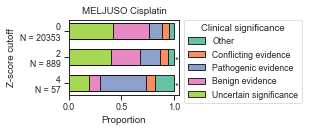

In [27]:
col = 'MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score'
bound_edit_dist = get_clinsig_dist_df(high_quality_edits, col, cutoffs)
plot_clinsig_dist(bound_edit_dist, col)
i = 2
for name, df in bound_edit_dist.groupby('cutoff'):
    chisq = stats.chisquare(df.n, ref_vals)
    print(name)
    print(chisq)
    if chisq[1] < 1e-16:
        plt.annotate('*', (1.01, i-0.2))
    i -= 1
plt.ylabel('Z-score cutoff')
plt.xlabel('Proportion')
plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/clean_edits_melj_cis_dist.svg', dpi = 150, bbox_inches = "tight")

In [28]:
bound_edit_dist

,Condensed Clinical Significance,n,cutoff,total,fraction,name
0,Uncertain significance,8553,0,20353,0.420233,0\nN = 20353
1,Benign evidence,7002,0,20353,0.344028,0\nN = 20353
2,Pathogenic evidence,2626,0,20353,0.129023,0\nN = 20353
3,Conflicting evidence,1346,0,20353,0.066133,0\nN = 20353
4,Other,826,0,20353,0.040584,0\nN = 20353
0,Uncertain significance,356,2,889,0.400450,2\nN = 889
1,Benign evidence,247,2,889,0.277840,2\nN = 889
2,Pathogenic evidence,174,2,889,0.195726,2\nN = 889
3,Conflicting evidence,62,2,889,0.069741,2\nN = 889
4,Other,50,2,889,0.056243,2\nN = 889


#### DNA Repair Enrichment

In [29]:
def get_string_ids(gene_symbols):
    # Get the string ids for querying the string database
    request_url = build_request_url("get_string_ids")
    params = {
        "identifiers" : "\r".join(gene_symbols), # your protein list
        "species" : 9606, # species NCBI identifier 
        "limit" : 1, # only one (best) identifier per input protein
        "echo_query" : 1 # see your input identifiers in the output
    }
    results = requests.post(request_url, data=params)
    df = handle_results(results)
    return df

genes = lfcs.Gene.unique()
string_ids = get_string_ids(genes)
string_ids.head()

,queryItem,queryIndex,stringId,ncbiTaxonId,taxonName,preferredName,annotation
0,FANCA,0,9606.ENSP00000373952,9606,Homo sapiens,FANCA,Fanconi anemia group A protein; DNA repair protein that may operate in a postreplication repair ...
1,FANCC,1,9606.ENSP00000289081,9606,Homo sapiens,FANCC,Fanconi anemia group C protein; DNA repair protein that may operate in a postreplication repair ...
2,LDLR,10,9606.ENSP00000454071,9606,Homo sapiens,LDLR,"Low-density lipoprotein receptor; Binds LDL, the major cholesterol-carrying lipoprotein of plasm..."
3,FAN1,100,9606.ENSP00000354497,9606,Homo sapiens,FAN1,Fanconi-associated nuclease 1; Nuclease required for the repair of DNA interstrand cross-links (...
4,LAMP2,1000,9606.ENSP00000408411,9606,Homo sapiens,LAMP2,Lysosome-associated membrane glycoprotein 2; Plays an important role in chaperone-mediated autop...


In [30]:
def get_terms(string_ids):
    # get pathways each gene is involved in
    request_url = build_request_url("functional_annotation")
    term_list = []
    # limited to 2000 queries by string
    for i in range(0, len(string_ids), 2000):
        curr_ids = string_ids[i:(i+2000)]
        params = {
            "identifiers" : "\r".join(curr_ids), # your protein list
            "species" : 9606, # species NCBI identifier
        }
        results = requests.post(request_url, data=params)
        df = handle_results(results)
        term_list.append(df)
    term_df = pd.concat(term_list)
    return term_df

term_df = get_terms(string_ids.stringId)
term_df['inputGenes'] = term_df.inputGenes.str.split(',')
long_terms = term_df[['category', 'term', 'inputGenes', 'description']].explode('inputGenes')
long_terms.head()

,category,term,inputGenes,description
0,Component,GO:0000015,9606.ENSP00000324105,phosphopyruvate hydratase complex
1,Component,GO:0000109,9606.ENSP00000265038,nucleotide-excision repair complex
1,Component,GO:0000109,9606.ENSP00000285021,nucleotide-excision repair complex
1,Component,GO:0000109,9606.ENSP00000310520,nucleotide-excision repair complex
1,Component,GO:0000109,9606.ENSP00000364270,nucleotide-excision repair complex


In [31]:
resp_dna_dam = (long_terms[long_terms.term == 'HSA-73894'] # Go list: GO:0006281, Reactome list
                .merge(string_ids, how = 'inner', 
                       right_on = 'stringId', left_on = 'inputGenes'))
lfcs['DNA Repair'] = lfcs.Gene.isin(resp_dna_dam.queryItem)
def get_dna_repair_enrichment(col, df, cutoff):
    """Gets the fraction of guides involved in DNA damage repair.

    Args:
        col: Which column to draw values from
        df: lfc or z-score df with a binarized column for a gene being involved in DNA damage repair
        cutoff: z-score cutoff for a hit
    """
    # Label guides based on Z-score cutoff
    base_DDR = sum(df['DNA Repair'])
    base_n = df.shape[0]
    hit_df = df[df[col].abs() > cutoff]
    hit_DDR = sum(hit_df['DNA Repair'])
    hit_n = hit_df.shape[0]
    dna_damage_fraction = hit_DDR/hit_n
    _, pvalue = stats.fisher_exact([[base_n, hit_n], [base_DDR, hit_DDR]])
    return {'column': col, 'cutoff': cutoff, 'fraction': dna_damage_fraction, 
            'n': hit_df.shape[0], 'p-value': pvalue}

cols = ['MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score', 'HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score']
dna_enrichment_list = []
cutoffs = [0,2,4,6]
for col in cols:
    for cut in cutoffs:
        enrichment = get_dna_repair_enrichment(col, lfcs, cut)
        dna_enrichment_list.append(enrichment)
dna_enrichment_df = pd.DataFrame(dna_enrichment_list)
dna_enrichment_df['cell'] = [x[0] for x in dna_enrichment_df.column.str.split(';')]
dna_enrichment_df['cutoff'] = dna_enrichment_df['cutoff'].astype(str).replace({'0': 'None'})

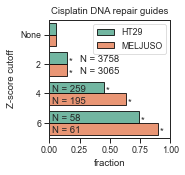

In [32]:
fig, ax = plt.subplots(figsize = cm2inch(5.5, 5.5))
ax = sns.barplot(data = dna_enrichment_df, y = 'cutoff', x = 'fraction', hue = 'cell', edgecolor = 'black',
           hue_order=['HT29', 'MELJUSO'])
plt.ylabel('Z-score cutoff')
plt.title('Cisplatin DNA repair guides')
plt.legend(title = '')
plt.xlim((0,1))
for i, row in dna_enrichment_df.iterrows():
    y_coord = ((i % 4) + 0.05) - np.sign(i-3.5)*0.2
    if row['p-value'] < 1e-16:
        plt.annotate('*', (row['fraction']+0.03, y_coord+0.05), 
                    ha = 'center', va = 'center')
    if row['fraction'] > 0.2:
        plt.annotate('N = ' + str(row['n']), (0.02, y_coord), va = 'center')
    elif row['cutoff'] != 'None': 
        plt.annotate('N = ' + str(row['n']), (0.25, y_coord), va = 'center')

plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/cisplatin_DDR.svg', bbox_inches = "tight", dpi = 150)

In [33]:
dna_enrichment_df


,column,cutoff,fraction,n,p-value,cell
0,MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score,None,0.058498,66789,1.000000e+00,MELJUSO
1,MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score,2,0.147798,3065,4.713449e-57,MELJUSO
2,MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score,4,0.635897,195,1.524157e-69,MELJUSO
3,MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score,6,0.901639,61,1.657802e-37,MELJUSO
4,HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score,None,0.058498,66789,1.000000e+00,HT29
5,HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score,2,0.143693,3758,2.411670e-63,HT29
6,HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score,4,0.451737,259,9.349466e-54,HT29
7,HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score,6,0.741379,58,2.718157e-27,HT29


## Relevant Genes
Here we ask which genes are relevant to a given arm (ie dropout, Cisplatin, Hygromycin or Rotenone). We run a t-test on the NO_SITE and ONE_NON-GENE_SITE controls separately and then require a threshold for both tests

In [34]:
high_impact_guides = vep_annotations.loc[vep_annotations.Impact == 'HIGH', 'sgRNA'].values
low_impact_guides = vep_annotations.loc[vep_annotations.Impact == 'LOW', 'sgRNA'].values
lfcs['High impact'] = lfcs['sgRNA sequence'].isin(high_impact_guides)
lfcs['Low impact'] = lfcs['sgRNA sequence'].isin(low_impact_guides)


In [35]:
gene_stats = []
lfc_cols = ['HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;lfc_dropout', 
            'MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;lfc_dropout']
for col in lfc_cols:
    print(col, end = "\n\n")
    no_site_lfcs = lfcs.loc[lfcs.Gene == 'NO_SITE', col].values
    mean_no_site = np.mean(no_site_lfcs)
    non_gene_lfcs = lfcs.loc[lfcs.Gene == 'ONE_NON-GENE_SITE', col].values
    mean_non_gene = np.mean(non_gene_lfcs)
    std_non_gene = np.std(non_gene_lfcs)
    for g in genes:
        print(g, end = "\r")
        gene_lfcs = lfcs.loc[lfcs.Gene == g] 
        query_lfcs_high = gene_lfcs.loc[gene_lfcs['High impact'], 
                                        col].values
        if len(query_lfcs_high) != 0:
            avg_zscore = np.mean((query_lfcs_high - mean_non_gene)/std_non_gene)
            mean_query = np.mean(query_lfcs_high)
            no_site_delta = mean_query - mean_no_site
            non_gene_delta = mean_query - mean_non_gene
            no_site_ks = stats.ks_2samp(query_lfcs_high, no_site_lfcs)
            non_gene_ks = stats.ks_2samp(query_lfcs_high, non_gene_lfcs)
            no_site_t = stats.ttest_ind(query_lfcs_high, no_site_lfcs)
            non_gene_t = stats.ttest_ind(query_lfcs_high, non_gene_lfcs)
        else:
            avg_zscore = np.NaN
            no_site_delta = np.NaN
            non_gene_delta = np.NaN
            no_site_ks = [np.NaN, np.NaN]
            non_gene_ks = [np.NaN, np.NaN]
            no_site_t = [np.NaN, np.NaN]
            non_gene_t = [np.NaN, np.NaN]

        gene_stats.append({'col': col, 'gene': g, 'n_total': gene_lfcs.shape[0],
                           'n_high': gene_lfcs[gene_lfcs['High impact']].shape[0],
                           'n_low': gene_lfcs[gene_lfcs['Low impact']].shape[0],
                           'no_site_ks': no_site_ks[0], 'no_site_ks_p': no_site_ks[1], 
                           'non_gene_ks': non_gene_ks[0], 'non_gene_ks_p': non_gene_ks[1],
                           'no_site_delta': no_site_delta, 'non_gene_delta': non_gene_delta,
                           'avg_zscore': avg_zscore, 'no_site_t': no_site_t[0], 
                           'no_site_t_p': no_site_t[1], 'non_gene_t': non_gene_t[0],
                           'non_gene_t_p': non_gene_t[1]})


HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;lfc_dropout



/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;lfc_dropout



We use the Benjamini-Hochberg procedure to define p-value cutoffs for each gene

In [36]:
gene_stat_df = pd.DataFrame(gene_stats)
gene_stat_df['non_gene_signif'] = (gene_stat_df.groupby('col')
                                   .non_gene_t_p
                                   .transform(lambda x: multipletests(x, alpha = 0.1, method = 'fdr_bh')[0]))
gene_stat_df['no_site_signif'] = (gene_stat_df.groupby('col')
                                   .no_site_t_p
                                   .transform(lambda x: multipletests(x, alpha = 0.1, method = 'fdr_bh')[0]))
gene_stat_df['condition'] = [x[0] + ' ' + x[3] for x in gene_stat_df.col.str.split(';')]
relevant_genes = gene_stat_df[gene_stat_df.non_gene_signif & gene_stat_df.no_site_signif]
relevant_genes.groupby("condition").agg({'gene': 'count'}).sort_values('gene')

/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/statsmodels/stats/multitest.py:325: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


,gene
condition,
MELJUSO Cisplatin,30
HT29 Cisplatin,62


In [37]:
melj_cis_hits = relevant_genes.loc[relevant_genes.condition == 'MELJUSO Cisplatin', 'gene']
ht29_cis_hits = relevant_genes.loc[relevant_genes.condition == 'HT29 Cisplatin', 'gene']
melj_cis_only = melj_cis_hits[~melj_cis_hits.isin(ht29_cis_hits)]
print('MELJUSO hits only: ' + str(len(melj_cis_only)))
ht29_cis_only =  ht29_cis_hits[~ht29_cis_hits.isin(melj_cis_hits)]
print('HT29 hits only: ' + str(len(ht29_cis_only)))
both_cis = ht29_cis_hits[ht29_cis_hits.isin(melj_cis_hits)]
print('Both hits: ' + str(len(both_cis)))
total_hits = set(melj_cis_hits.values).union(set(ht29_cis_hits.values))
print('Total hits: ' + str(len(total_hits)))

MELJUSO hits only: 13
HT29 hits only: 45
Both hits: 17
Total hits: 75


In [38]:
gene_stat_df['statistic'] = gene_stat_df.apply(lambda df: df['non_gene_t'] if abs(df['non_gene_t']) < abs(df['no_site_t']) else df['no_site_t'], axis = 1)

In [39]:
gene_stat_df.to_csv('/Users/pdeweird/Documents/BE_clinvar/Data/Enrichment/gene_stat_df.csv', index=False)

/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


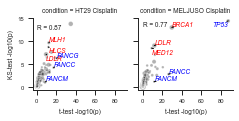

In [40]:
gene_stat_df['t_maxp'] = gene_stat_df[['non_gene_t_p', 'no_site_t_p']].max(axis = 1)
gene_stat_df['ks_maxp'] = gene_stat_df[['non_gene_ks_p', 'no_site_ks_p']].max(axis = 1)
gene_stat_df['t_nlogp'] = -np.log10(gene_stat_df['t_maxp'])
gene_stat_df['ks_nlogp'] = -np.log10(gene_stat_df['ks_maxp'])
cisplatin_stats = gene_stat_df[gene_stat_df.col.str.contains('Cisplatin')].copy()

def labelled_scatter(x, y, data = df, n = 5, **kwargs):
    data = data.copy()
    data['x_z'] = (data[x] - data[x].mean())/(data[x].std())
    data['y_z'] = (data[y] - data[y].mean())/(data[y].std())
    data['difference'] = data['x_z'] - data['y_z']
    data['min'] = np.minimum(data['x_z'], data['y_z'])
    bottom_difference = data.sort_values('difference').head(n)
    top_difference = data.sort_values('difference', ascending = False).head(n)
    agree = data.sort_values('min', ascending = False).head(n)
    ax = sns.scatterplot(x, y, data = data, **kwargs)
    texts = []
    r = np.round(stats.pearsonr(data[x], data[y])[0], 2)
    plt.text(data[x].min(), data[y].max(), 'R = ' + str(r), va = 'top', ha = 'left')
    # ensures text labels are non-overlapping
    for i, row in bottom_difference.iterrows():
        texts.append(plt.text(row[x], row[y], row['gene'], color = 'red', style = 'italic'))
    for i, row in top_difference.iterrows():
        texts.append(plt.text(row[x], row[y], row['gene'], color = 'blue', style = 'italic'))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
    
    
    return ax

sns.set(style='ticks', palette='Set2', font='Arial', context = 'paper', font_scale = 0.68)
g = sns.FacetGrid(col = 'condition', data = cisplatin_stats, size = 1.7)
g.map_dataframe(labelled_scatter, 't_nlogp', 'ks_nlogp', 
                size = 'n_high', n = 3, s = 50,  sizes=(5, 40), color = 'black', alpha = 0.3, linewidths = 0)
g.axes[0,0].set_xlabel('t-test -log10(p)')
g.axes[0,1].set_xlabel('t-test -log10(p)')
g.axes[0,0].set_ylabel('KS-test -log10(p)')
plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/tVks.svg')

In [41]:
sns.set(style='ticks', palette='Set2', font='Arial', context = 'paper')

In [42]:
cisplatin_stats['DNA Repair'] = cisplatin_stats.gene.isin(resp_dna_dam.queryItem)
def quick_auc(classes, probs):
    fpr, tpr, threshold = roc_curve(classes, probs)
    return auc(fpr, tpr)
print('T-test:')
print(cisplatin_stats[['condition','DNA Repair', 't_maxp']]
 .dropna()
 .groupby('condition')
 .apply(lambda df: quick_auc(df['DNA Repair'], 1 - df['t_maxp'])))  
print('KS-test:')
print(cisplatin_stats[['condition','DNA Repair', 'ks_maxp']]
 .dropna()
 .groupby('condition')
 .apply(lambda df: quick_auc(df['DNA Repair'], 1 - df['ks_maxp']))) 

T-test:
condition
HT29 Cisplatin       0.752959
MELJUSO Cisplatin    0.716376
dtype: float64
KS-test:
condition
HT29 Cisplatin       0.672889
MELJUSO Cisplatin    0.646680
dtype: float64


In [43]:
filtered_stat_df = gene_stat_df[(gene_stat_df.n_high > 1)].copy()
spread_tscore = (filtered_stat_df[['col', 'gene', 'statistic']].pivot(columns = 'col', 
                                                                    values = 'statistic', 
                                                                    index = 'gene')
                .reset_index()
                .dropna())

In [44]:
top_n = 7
top_genes = gene_stat_df[(gene_stat_df.n_high > 3) & (gene_stat_df.n_low > 3) & 
                         gene_stat_df.non_gene_signif & gene_stat_df.no_site_signif].copy()
top_genes['abs_stat'] = top_genes.statistic.abs()
top_genes = (top_genes.sort_values('abs_stat', ascending = False)
             .groupby('col')
             .head(top_n))
cisplatin_labels = top_genes[top_genes.col.str.contains('Cisplatin')].gene.values

/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/seaborn/relational.py:918: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  scout = ax.scatter([], [], **kws)
/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/seaborn/relational.py:955: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  points = ax.scatter(*args, **kws)


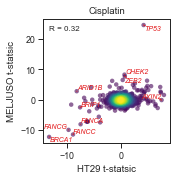

In [45]:
def plot_t_hits(x, y, df, figsize = (5.25,5.25), label = []):
    """Plot the direction -log10(max p-value) comparing conditions
    
    Args:
        x: x
        y: y
        df: gene stat df
        figsize: figure size
        label: genes to label
    """
    fig, ax = plt.subplots(figsize = cm2inch(figsize))
    ax = point_density_plot(x, y, df, s = 20, ax = ax)
    plt.xlabel(x.split(';')[0] + ' t-statsic')
    plt.ylabel(y.split(';')[0] + ' t-statsic')
    plt.title(x.split(';')[3])
    texts = []
    hit_df = df[df.gene.isin(label)]
    for i, row in hit_df.iterrows():
        texts.append(plt.text(row[x], row[y], row['gene'], size=7, color = '#e31a1c', style = 'italic'))
    # ensures text labels are non-overlapping
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='#e31a1c', lw=1))
    return fig, ax

# it's a bit confusing with the lfc in the column name, but this was just the column used to
# calculate the ks statistic
fig, ax = plot_t_hits('HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;lfc_dropout', 
                       'MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;lfc_dropout',
                       spread_tscore, figsize = (5.75, 5.75), label = cisplatin_labels)
fig.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/mint_cisplatin.svg', bbox_inches = "tight", dpi = 150)

In [46]:
def plot_hit_distribution(col, genes, lfcs, figsize = (3.5,8), no_site = True, 
                          non_gene = True, mean = True, ctl_scale = True, impact = False, 
                          non_gene_hue = 'black', no_site_hue = 'grey', guide_alpha = 0.3, 
                          stat_df = None):
    """Plots distribution of genes in a given condition.

    Creates a rugplot with density estimate for the lfc's or z-scores
    of a gene. Each gene has its own subplot. The first subplot has the 
    density estimate for controls.

    Args:
        col: Which column to draw values from
        genes: List of gene symbols
        figsize: Overall figure size in cms
        no_site: whether to include no site controls
        non_gene: " one non-gene site "
        mean: whether to include the mean of controls
        ctl_scale: whether to include density scale for controls
        impact: color guides by impact
        non_gene_hue: color of non_gene controls
        
    """
    # make each subplot the same height
    height_ratios = [1]
    for g in genes:
        height_ratios.append(1)
    plt.figure(figsize=cm2inch(figsize))
    gs = gridspec.GridSpec(len(genes)+1, 1, height_ratios=height_ratios) 
    # controls axis
    ax0 = plt.subplot(gs[0])
    if not ctl_scale:
        ax0.get_yaxis().set_ticks([])
        plt.ylabel('Controls', rotation='horizontal', ha = 'right', va = 'center')
    legend_labels = []
    if no_site:
        no_site_lfcs = lfcs.loc[lfcs.Gene == 'NO_SITE', col]
        sns.kdeplot(no_site_lfcs, ax = ax0, color = no_site_hue)
        legend_labels.append('Non-targeting')
    if non_gene:
        non_gene_lfcs = lfcs.loc[lfcs.Gene == 'ONE_NON-GENE_SITE', col]
        sns.kdeplot(non_gene_lfcs, ax = ax0, color = non_gene_hue)
        legend_labels.append('Intergenic')
    if mean:
        if no_site:
            ax0.axvline(x=no_site_lfcs.mean(), color = no_site_hue, linestyle = '--')
        if non_gene:
            ax0.axvline(x=non_gene_lfcs.mean(), color = non_gene_hue, linestyle = '--')        
    ax0.legend(labels = legend_labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
    # Set the subfigure size to encapsulate the range of values
    if impact:
        plt.xlim((lfcs.loc[(lfcs.Gene.isin(genes) & (lfcs['High impact'] | lfcs['Low impact'])) | lfcs.Gene.isin(['NO_SITE', 'ONE_NON-GENE_SITE']),col].min() - 2,
                  lfcs.loc[(lfcs.Gene.isin(genes) & (lfcs['High impact'] | lfcs['Low impact']))| lfcs.Gene.isin(['NO_SITE', 'ONE_NON-GENE_SITE']),col].max() + 2))
    else:
        plt.xlim((lfcs.loc[lfcs.Gene.isin(genes) | lfcs.Gene.isin(['NO_SITE', 'ONE_NON-GENE_SITE']),col].min() - 2,
                  lfcs.loc[lfcs.Gene.isin(genes) | lfcs.Gene.isin(['NO_SITE', 'ONE_NON-GENE_SITE']),col].max() + 2))
    plt.setp(ax0.get_xticklabels(), visible=False)
    split_col = col.split(';')
    plt.title(split_col[0] + ' ' + split_col[3])
    # subplots for each gene
    if (stat_df is not None) & (len(genes) > 0):
        stat_df = stat_df.copy()
        stat_df['stat_text'] = stat_df.statistic.apply(lambda x: 't = ' + str(np.round(x, 1)))
        stat_df['direction'] = np.sign(stat_df.statistic)
    # store gene subplots in a list
    axs = []
    for i in range(len(genes)):
        axs.append(plt.subplot(gs[i+1], sharex=ax0))
        if impact:
            high_lfcs = lfcs.loc[(lfcs.Gene == genes[i]) & 
                                 (lfcs['High impact']), col]
            sns.distplot(high_lfcs, rug_kws = {'height' : 1, 'color': '#fc8d62', 
                                               'alpha': guide_alpha,'linewidth': 0.5}, 
                         kde_kws = {'color': '#fc8d62'},
                         ax = axs[-1], hist = False, rug = True)
            low_lfcs = lfcs.loc[(lfcs.Gene == genes[i]) & 
                                 (lfcs['Low impact']), col]
            if low_lfcs.shape[0] > 0:
                sns.distplot(low_lfcs, rug_kws = {'height' : 1, 'color': '#8da0cb',
                                                  'alpha': guide_alpha,'linewidth': 0.5}, 
                             kde_kws = {'color': '#8da0cb'}, ax = axs[-1], hist = False, rug = True)
        else:   
            gene_lfcs = lfcs.loc[lfcs.Gene == genes[i], col]
            sns.distplot(gene_lfcs, rug_kws = {'height' : 1, 
                                               'color': 'grey',
                                               'alpha': guide_alpha,'linewidth': 0.5}, 
                         kde_kws = {'color': 'darkgrey'},
                         ax = axs[-1], 
                         hist = False, rug = True)
        axs[-1].get_yaxis().set_ticks([])
        if mean:
            if no_site:
                axs[-1].axvline(x=no_site_lfcs.mean(), color = no_site_hue, linestyle = '--')
            if non_gene:
                axs[-1].axvline(x=non_gene_lfcs.mean(), color = non_gene_hue, linestyle = '--')       
        if i != (len(genes) - 1):
            plt.setp(axs[-1].get_xticklabels(), visible=False)
        if stat_df is not None:
            gene_stat_df = stat_df[stat_df.gene == genes[i]]
            xmin, xmax = plt.xlim()
            ymin, ymax = plt.ylim()
            if gene_stat_df['direction'].values[0] == -1:
                axs[-1].annotate(gene_stat_df['stat_text'].values[0], (xmax - 0.02*(xmax - xmin), 0.05*(ymax - ymin)), 
                                 ha = 'right', va = 'bottom', size = 6)
            elif gene_stat_df['direction'].values[0] == 1:
                axs[-1].annotate(gene_stat_df['stat_text'].values[0], (xmin + 0.02*(xmax - xmin), 0.05*(ymax - ymin)), 
                                 ha = 'left', va = 'bottom', size = 6)
        plt.xlabel('')
        plt.ylabel(genes[i], rotation='horizontal', ha = 'right', va = 'center', style = 'italic')

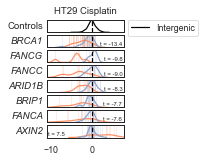

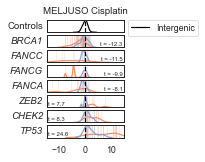

In [47]:
sns.set(style='white', palette='Set2', font='Arial', context = 'paper')
zscore_cols = ['HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score', 'MELJUSO;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score']
for col in zscore_cols:
    split_col = col.split(';')
    col_stat_df = top_genes[top_genes.condition == split_col[0] + ' ' + split_col[3]].sort_values('no_site_t')
    plot_hit_distribution(col, col_stat_df['gene'].values, 
                          lfcs, ctl_scale=False, figsize = (3.5,5.5), no_site = False,
                          impact = True, stat_df = col_stat_df)
    plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/' + split_col[0] + '_' + split_col[3] + '_hit_dist.svg', bbox_inches = "tight")

In [48]:
sns.set(style='ticks', palette='Set2', font='Arial', context = 'paper')


In [49]:
gene_stat_df.loc[(gene_stat_df.gene == 'TP53') & gene_stat_df.col.str.contains('Cisplatin'), ['gene','condition','no_site_t', 'non_gene_t']]

,gene,condition,no_site_t,non_gene_t
145,TP53,HT29 Cisplatin,4.204399,4.172964
4256,TP53,MELJUSO Cisplatin,26.037291,24.621755


In [50]:
gene_stat_df.loc[(gene_stat_df.gene == 'AXIN2') & gene_stat_df.col.str.contains('Cisplatin'), ['gene','condition','no_site_t', 'non_gene_t']]

,gene,condition,no_site_t,non_gene_t
280,AXIN2,HT29 Cisplatin,7.792038,7.52229
4391,AXIN2,MELJUSO Cisplatin,-0.192055,-0.11385


In [51]:
gene_stat_df.loc[(gene_stat_df.gene == 'LDLR') & gene_stat_df.col.str.contains('Cisplatin'), ['gene','condition','no_site_t', 'non_gene_t']]

,gene,condition,no_site_t,non_gene_t
10,LDLR,HT29 Cisplatin,-7.011736,-6.380588
4121,LDLR,MELJUSO Cisplatin,-8.063659,-7.246811


Enrichment for hit genes in DDR

In [52]:
potential_hits = gene_stat_df[['gene', 'n_high']].drop_duplicates()
potential_hits = potential_hits[potential_hits.n_high > 1]

In [53]:
potential_string_genes = sum(string_ids.queryItem.isin(potential_hits.gene)) #note that we have more string genes than we do clinvar genes since we're including essential splice sites et
potential_dna_repair_genes = sum(resp_dna_dam.queryItem.isin(potential_hits.gene))
cisplatin_hit_df = cisplatin_stats.loc[cisplatin_stats['non_gene_signif'] & cisplatin_stats['no_site_signif'], ['gene', 'DNA Repair']].drop_duplicates()
cisplatin_hits = cisplatin_hit_df.shape[0]
cistplatin_DDR_hits = sum(cisplatin_hit_df['DNA Repair'])
contingency_table = [[potential_string_genes, cisplatin_hits], [potential_dna_repair_genes, cistplatin_DDR_hits]]
print(contingency_table)
print(stats.fisher_exact(contingency_table))


[[993, 75], [39, 21]]
(7.1292307692307695, 2.180291582004888e-09)


Enrichment for hit genes in chromatin organization

In [54]:
chrom_org = (long_terms[long_terms.term == 'GO:0051276'] 
             .merge(string_ids, how = 'inner', 
                    right_on = 'stringId', left_on = 'inputGenes'))
cisplatin_stats['Chrom Org'] = cisplatin_stats.gene.isin(chrom_org.queryItem)
cisplatin_hit_df = cisplatin_stats.loc[cisplatin_stats['non_gene_signif'] & cisplatin_stats['no_site_signif'], ['gene', 'Chrom Org']].drop_duplicates()
potential_chrom_org_genes = sum(chrom_org.queryItem.isin(potential_hits.gene))
cistplatin_chrom_org_hits = sum(cisplatin_hit_df['Chrom Org'])
contingency_table = [[potential_string_genes, cisplatin_hits], [potential_chrom_org_genes, cistplatin_chrom_org_hits]]
print(contingency_table)
print(stats.fisher_exact(contingency_table))


[[993, 75], [83, 32]]
(5.104578313253012, 3.624640821908357e-10)


## Hygromycin

/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/seaborn/relational.py:918: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  scout = ax.scatter([], [], **kws)
/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/seaborn/relational.py:955: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  points = ax.scatter(*args, **kws)


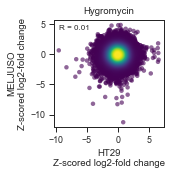

In [55]:
fig, ax = plt.subplots(figsize = cm2inch((5, 5)))
ax = point_density_plot('HT29;AADW08;RDA077;Hygromycin;AvgABC;D21;z_score', 
                        'MELJUSO;AADW08;RDA077;Hygromycin;AvgABC;D21;z_score', lfcs, s=20, ax=ax)
plt.xlabel('HT29\nZ-scored log2-fold change')
plt.ylabel('MELJUSO\nZ-scored log2-fold change')
plt.title('Hygromycin')
plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/hygro_guides.svg', dpi = 150, bbox_inches = "tight")

In [56]:
(lfcs.loc[:, ['Gene','sgRNA','Strand', 'HT29;AADW08;RDA077;Dropout;AvgABC;D21;z_score','HT29;AADW08;RDA077;Hygromycin;AvgABC;D21;z_score', 'MELJUSO;AADW08;RDA077;Dropout;AvgABC;D21;z_score', 'MELJUSO;AADW08;RDA077;Hygromycin;AvgABC;D21;z_score']]
 .sort_values('HT29;AADW08;RDA077;Hygromycin;AvgABC;D21;z_score')
 .tail(15))

,Gene,sgRNA,Strand,HT29;AADW08;RDA077;Dropout;AvgABC;D21;z_score,HT29;AADW08;RDA077;Hygromycin;AvgABC;D21;z_score,MELJUSO;AADW08;RDA077;Dropout;AvgABC;D21;z_score,MELJUSO;AADW08;RDA077;Hygromycin;AvgABC;D21;z_score
15841,PMS2,TATTCAACATTAATATGGTA,sense,-2.286205,4.623591,-1.648813,0.944412
44349,AXIN2,CCGAGCTCACACTCAATTCG,antisense,-0.906883,4.743394,-0.246159,1.155373
19654,RAPSN,TCTGCTTCGCTGACATCCAC,antisense,-2.542242,4.781903,-1.104506,-0.827961
17970,SMARCE1,AAACGAATACGAAGCAGAAA,antisense,-3.455701,5.346139,-1.680890,-3.183306
43102,GJB2,GTCCACGCCAGCGCTCCTAG,antisense,-1.052331,5.443899,-0.601129,1.106095
50949,GJB1,CAGTCCACTGTGTTGGGGCA,antisense,0.247850,5.565001,0.856164,0.582844
27303,GJB2,ATAGCCGGATGTGGGAGATG,sense,0.902432,5.699439,1.291061,-0.615440
22811,GJB2,CAGGGCCCATAGCCGGATGT,sense,0.837506,5.867187,1.156963,0.225945
42159,GJB2,GAGCCAGATCTTTCCAATGC,sense,0.196989,5.904499,0.477056,0.702670
31416,GJB2,CAGTCCACAGTGTTGGGACA,sense,0.200678,5.963122,0.539679,-0.436605


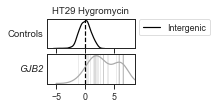

In [57]:
col = 'HT29;AADW08;RDA077;Hygromycin;AvgABC;D21;z_score'
plot_hit_distribution(col, ['GJB2'], 
                      lfcs, ctl_scale=False, figsize = (4,3), no_site = False,
                      impact = False)
plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/GJB2_guides_noimpact.svg', dpi = 150, bbox_inches = "tight")

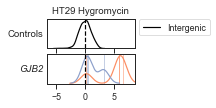

In [58]:
plot_hit_distribution(col, ['GJB2'], 
                      lfcs, ctl_scale=False, figsize = (4,3), no_site = False,
                      impact = True, guide_alpha = 1)
plt.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/GJB2_guides_impact.svg', dpi = 150, bbox_inches = "tight")